In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# **Dataset Description**

**Predict sentiment of movie reviews.**

Files

train.csv - the training set containing the review sentiment along with other features.

test.csv - the test set, has review features, but no sentiment column, since it is the target.

movies.csv - the file with metadata on movie data

# **Importing Necessary Libraries**

In [ ]:
#Importing important libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
import re
from sklearn.model_selection import train_test_split
from scipy.sparse import hstack
from sklearn.model_selection import  cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import TruncatedSVD
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from scipy.special import expit
from sklearn.naive_bayes import ComplementNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

# **Loading Data**

In [ ]:
movie_data = pd.read_csv("/kaggle/input/sentiment-prediction-on-movie-reviews/movies.csv") 
train_data = pd.read_csv("/kaggle/input/sentiment-prediction-on-movie-reviews/train.csv")
test_data = pd.read_csv("/kaggle/input/sentiment-prediction-on-movie-reviews/test.csv")
sample_data = pd.read_csv("/kaggle/input/sentiment-prediction-on-movie-reviews/sample.csv")

In [ ]:
movie_data.head()

In [ ]:
movie_data.info()

# **EDA on Movie data**

In [ ]:
movie_data.shape

In [ ]:
movie_data.isnull().sum()

**Removing columns from movie_data in which more than 80 percent value is missing**

In [ ]:
# Set the threshold for the maximum allowable missing values
threshold = 0.8  # Remove columns with more than 80% missing values

# Calculate the percentage of missing values in each column
missing_percentage = movie_data.isnull().mean()

# Identify columns with missing values exceeding the threshold
columns_to_drop = missing_percentage[missing_percentage > threshold].index

# Remove the columns with the most missing values
movie_data = movie_data.drop(columns=columns_to_drop)

# Create a bar chart to visualize missing values
plt.figure(figsize=(10, 6))
sns.barplot(x=missing_percentage.index, y=missing_percentage.values * 100, palette='viridis')
plt.xticks(rotation=90)
plt.title('Percentage of Missing Values in Columns')
plt.xlabel('Columns')
plt.ylabel('Percentage of Missing Values')
plt.tight_layout()
plt.show()

**Droped Columns name in which 80% data is missing**

In [ ]:
print(columns_to_drop,'\n',len(columns_to_drop))

Index(['rating', 'ratingContents', 'boxOffice', 'distributor', 'soundType'], dtype='object') 
 5

In [ ]:
movie_data.info()

# **Cleaning movie_data for merge operation with train_data**

**Filter movie_data for rows where audienceScore and originalLanguage are not empty**

In [ ]:
not_empty_df = movie_data[~(movie_data['audienceScore'].isnull() | movie_data['originalLanguage'].isnull())]

# Print the not_empty_df DataFrame
not_empty_df.head()

**DataFrame where audienceScore and originalLanguage are NaN**

In [ ]:
nan_df = movie_data[(movie_data['audienceScore'].isnull()) & (movie_data['originalLanguage'].isnull())]

#Print nan_df DataFrame
nan_df.head()

**Filter movie_data for rows where audienceScore is empty but originalLanguage is not empty**

In [ ]:
audience_nan_df = movie_data[movie_data['audienceScore'].isnull() & ~movie_data['originalLanguage'].isnull()]

# Print the audience_nan_df DataFrame
audience_nan_df.head()

**Filter movie_data for rows where audienceScore is not empty but originalLanguage is  empty**

In [ ]:
language_nan_df = movie_data[~movie_data['audienceScore'].isnull() & movie_data['originalLanguage'].isnull()]

# Print the language_nan_df DataFrame
language_nan_df.head()

**Selecting movieid from each dataframe** 

In [ ]:
not_empty_ids=not_empty_df['movieid']
language_nan_ids=language_nan_df['movieid']
audience_nan_ids=audience_nan_df['movieid']
nan_ids=nan_df['movieid']

**Removing intersection between dataframes with audienceScore not null and originalLanguage null**

In [ ]:
movie_data = movie_data[~(movie_data['movieid'].isin(not_empty_ids) & movie_data['movieid'].isin(language_nan_ids) &
                        ~movie_data['audienceScore'].isnull() & movie_data['originalLanguage'].isnull())]

movie_data = movie_data[~(movie_data['movieid'].isin(nan_ids) & movie_data['movieid'].isin(language_nan_ids) &
                      ~movie_data['audienceScore'].isnull() & movie_data['originalLanguage'].isnull())]

movie_data = movie_data[~(movie_data['movieid'].isin(audience_nan_ids) & movie_data['movieid'].isin(language_nan_ids) &
                         ~movie_data['audienceScore'].isnull() & movie_data['originalLanguage'].isnull())]

**Removing intersection between dataframes with audienceScore null and originalLanguage not null**

In [ ]:
movie_data = movie_data[~(movie_data['movieid'].isin(not_empty_ids) & movie_data['movieid'].isin(audience_nan_ids) &
                        movie_data['audienceScore'].isnull() & ~movie_data['originalLanguage'].isnull())]


movie_data = movie_data[~(movie_data['movieid'].isin(nan_ids) & movie_data['movieid'].isin(audience_nan_ids) &
                        movie_data['audienceScore'].isnull() & ~movie_data['originalLanguage'].isnull())]


movie_data = movie_data[~(movie_data['movieid'].isin(language_nan_ids) & movie_data['movieid'].isin(audience_nan_ids) &
                        movie_data['audienceScore'].isnull() & ~movie_data['originalLanguage'].isnull())]

**Removing intersection between dataframes with audienceScore null and originalLanguage null**

In [ ]:
movie_data = movie_data[~(movie_data['movieid'].isin(not_empty_df) & movie_data['movieid'].isin(nan_ids) &
                        movie_data['audienceScore'].isnull() & movie_data['originalLanguage'].isnull())]


movie_data = movie_data[~(movie_data['movieid'].isin(language_nan_ids) & movie_data['movieid'].isin(nan_ids) &
                        movie_data['audienceScore'].isnull() & movie_data['originalLanguage'].isnull())]

movie_data = movie_data[~(movie_data['movieid'].isin(audience_nan_ids) & movie_data['movieid'].isin(nan_ids) &
                        movie_data['audienceScore'].isnull() & movie_data['originalLanguage'].isnull())]

In [ ]:
movie_data.info()

# **Using simple imputer to impute missing values in audienceScore column**

In [ ]:
# Create a SimpleImputer object with strategy "mean" 
imputer = SimpleImputer(strategy='mean')

# Reshape the 'audienceScore' column 
audience_scores = movie_data['audienceScore'].values.reshape(-1, 1)

# Fit imputer
filled_scores = imputer.fit_transform(audience_scores)

# Update the 'audienceScore' column in the DataFrame with the filled values
movie_data['audienceScore'] = filled_scores

In [ ]:
#All empty cells are imputed 
movie_data['audienceScore'].isnull().sum()

# ** Group the DataFrame by 'movieid', aggregate original languages as a list, and calculate the mean of audience scores**
**For Example**
 movieid  originalLanguage  audienceScore 

 1        English           4.5           
 2        Spanish           3.8           
 3        English           4.0           
 4        French            4.2           
 1        English           4.7           
 3        French            4.5           
**Is converted to**
 movieid  originalLanguage  audienceScore 

 1        [English, English]  4.6         
 2        [Spanish]           3.8         
 3        [English, French]   4.25        
 4        [French]            4.2         

In [ ]:
#Grouping and Aggregating:
grouped_movies = movie_data.groupby('movieid').agg({'originalLanguage': list, 'audienceScore': 'mean'}).reset_index()

# Drop duplicate movie IDs from the original dataframe
movie_data_unique = movie_data.drop_duplicates(subset='movieid')

# Merge the unique movie IDs with the corresponding original languages and mean audience scores
movie_data_unique = movie_data_unique.merge(grouped_movies, on='movieid', how='left')

In [ ]:
movie_data_unique.head()

In [ ]:
movie_data_unique.isnull().sum()

**Removing Redundant audienceScore_x and originalLanguage_x columns**

In [ ]:
# Specify the list of columns to remove
columns_to_remove = ['audienceScore_x', 'originalLanguage_x']

# Remove the specified columns from the DataFrame
movie_data_unique = movie_data_unique.drop(columns=columns_to_remove)

In [ ]:
movie_data_unique.info()

**proving that duplicates are removed from movieid**

In [ ]:
check=movie_data_unique['movieid'].value_counts().tolist()
unique=[]
for i in check:
    if i not in unique:
        unique.append(i)
print(unique)

# **Preprocessing train data**

In [ ]:
train_data.head()

In [ ]:
train_data.shape

In [ ]:
train_data.info()

In [ ]:
train_data.isnull().sum()

**I have taken decision to drop because empty cell in reviewText column is around 3.96% of total data**

In [ ]:
train_data = train_data.dropna(subset=['reviewText'], how='all')

In [ ]:
train_data.isnull().sum()

In [ ]:
movie_data=movie_data_unique.copy() 

# **Merging train_data and movie_data on the basis of movie id** 

In [ ]:
#merging movie and train data 
movie_training_data = movie_data.merge(train_data, on='movieid')

In [ ]:
movie_training_data.head(3)

# **PreProcess movie_training_data**

In [ ]:
movie_training_data.shape

In [ ]:
movie_training_data.info()

In [ ]:
movie_training_data.isnull().sum()

In [ ]:
movie_training_data['sentiment'].value_counts()

In [ ]:
movie_training_data['isFrequentReviewer'].value_counts()

# **Applying LabelEncoder on en_list element**

In [ ]:
en_list=['isFrequentReviewer', 'sentiment']
encoder=LabelEncoder()
movie_training_data[en_list[0]] =encoder.fit_transform(movie_training_data[en_list[0]])
movie_training_data[en_list[1]] =encoder.fit_transform(movie_training_data[en_list[1]])

In [ ]:
movie_training_data['sentiment'].value_counts(),movie_training_data['isFrequentReviewer'].value_counts()

# **Making pipeline for data processing**

In [ ]:
cat_list=['releaseDateTheaters', 'releaseDateStreaming', 'genre']
num_list=['runtimeMinutes', 'audienceScore_y']

steps_cat=[('impute',SimpleImputer(fill_value='None',strategy='constant'))]

steps_num_1=[('s',MinMaxScaler(feature_range=(0,1), copy=True))]

steps_num_2=[('impute',SimpleImputer(strategy='mean'))]

pipe_1=Pipeline(steps_cat)
pipe_2=Pipeline(steps_num_1)
pipe_3=Pipeline(steps_num_2)

**Using column transformer to apply pipeline to specific columns**

In [ ]:
ct = ColumnTransformer([
    ('cat_impute', pipe_1, cat_list),
    ('num_pipe_1', pipe_3, [num_list[0]]),
    ('num_pipe_2',pipe_2, [num_list[1]])
], remainder='passthrough')

New_data=ct.fit_transform(movie_training_data.copy())

In [ ]:
New_data[0]

**Converting numpy array to dataframe**

In [ ]:
new_training_data=pd.DataFrame(New_data,columns=['releaseDateTheaters', 'releaseDateStreaming','genre',
                                                   'runtimeMinutes','audienceScore_y','movieid', 'title',
       'director', 'originalLanguage_y', 'reviewerName', 'isFrequentReviewer', 'reviewText',
       'sentiment'])

In [ ]:
new_training_data.head(3)

**Ordering column with respect to movie_training_data**

In [ ]:
new_training_data=new_training_data[movie_training_data.columns]

**Changing data type with respect to movie_training_data**

In [ ]:
for col in movie_training_data.columns:
    new_training_data[col] = new_training_data[col].astype(movie_training_data[col].dtype)
movie_training_data=new_training_data.copy()

In [ ]:
movie_training_data.head(3)

In [ ]:
movie_training_data.isnull().sum()

In [ ]:
movie_training_data.info()

# **Performing EDA on movie_training_data**

In [ ]:
movie_training_data.shape

In [ ]:
movie_training_data.describe()

In [ ]:
movie_training_data.info()

**Here I have plotted bar graph to show data inbalance in sentiment column**


**From plot i can say data inbalance is not very significant but i will try smote to reduce this inbalance**

In [ ]:
Count_data_1=movie_training_data['sentiment'].value_counts()
total_rows=(movie_training_data['sentiment'].shape)[0]

#Working on style of plot  
sns.set_style('whitegrid')
sns.set(font_scale=1.2)
sns.set_palette("deep", 10)

#Actual plot 
plt.figure(figsize=(10, 6))
sns.barplot(x=Count_data_1.index, y=(Count_data_1.values/total_rows)*100)
plt.title('Data inbalance in sentiment column')
plt.xlabel('label')
plt.ylabel('percentage')
plt.tight_layout()
plt.show()

**Count of frequent reviewer**

In [ ]:
len(((movie_training_data[movie_training_data['isFrequentReviewer']==1])['reviewerName']).unique())

# **Correleation between numerical columns with sentiments**

**From below heat map I can see that audience score is some what related with sentiment so it can be taken as feature** 

In [ ]:
#calculating correlation between numeric_columns and sentiment
#selecting all numerical colum
numeric_columns=movie_training_data.select_dtypes(include=['float64','int64'])
correlation_matrix=numeric_columns.corrwith(movie_training_data['sentiment'])

#plotting
plt.figure(figsize=(6,3))
sns.heatmap(correlation_matrix.to_frame(),annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap of numeric column with sentiment column')
plt.show()

**As we can see below that catagorical columns below have high unique values so finding correlation between these columns and sentiment does not make sense**

In [ ]:
for col in movie_training_data.select_dtypes('object'):
    if col!='originalLanguage_y':
        print(col,len(movie_training_data[col].unique()))

# **Feature Engineering**

In [ ]:
new_data=movie_training_data.copy()

**Removing old features**

In [ ]:
# Specify the list of columns to remove
columns_to_remove = ['releaseDateTheaters', 'releaseDateStreaming','runtimeMinutes','genre','director','originalLanguage_y','audienceScore_y','reviewerName','isFrequentReviewer']

# Remove the specified columns from the DataFrame
new_data = new_data.drop(columns=columns_to_remove)
new_data.head()

**Generating new features**

In [ ]:
# Feature Engineering
train_df_fe = new_data.copy()

train_df_fe['tweet_length'] = train_df_fe['reviewText'].str.len()
train_df_fe['num_hashtags'] = train_df_fe['reviewText'].str.count('#')
train_df_fe['num_exclamation_marks'] = train_df_fe['reviewText'].str.count('\!')
train_df_fe['num_question_marks'] = train_df_fe['reviewText'].str.count('\?')
train_df_fe['total_tags'] = train_df_fe['reviewText'].str.count('@')
train_df_fe['num_punctuations'] = train_df_fe['reviewText'].str.count('[.,:;]')
train_df_fe['num_question_marks'] = train_df_fe['reviewText'].str.count('[*&$%]')
train_df_fe['num_words'] = train_df_fe['reviewText'].apply(lambda x: len(x.split()))

train_df_fe.head()

**lower bound and upper bound of review length**

In [ ]:
min(train_df_fe['tweet_length'].values),max(train_df_fe['tweet_length'].values)

**Printing unique values in each columns**

In [ ]:
for col in train_df_fe.select_dtypes('int64'):
        print(col,len(train_df_fe[col].unique()))

In [ ]:
train_df_fe.info()

In [ ]:
train_df_fe.describe()

**Observing Correlation of new features with sentiment column**

**From observation I observed that newly created features are highly uncorrelated with sentiment hence I have not used them**

In [ ]:
#calculating correlation between numeric_columns and sentiment
#selecting all numerical colum
numeric_columns=train_df_fe.select_dtypes('int64')
correlation_matrix=numeric_columns.corrwith(train_df_fe['sentiment'])

#plotting
plt.figure(figsize=(6,3))
sns.heatmap(correlation_matrix.to_frame(),annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap of numeric column with sentiment column in train_df_fe')
plt.show()

# **Cleaning reviewText in movie_training_data**

In [ ]:
movie_training_data['reviewText'][0]

**Implementing clean_review_text function in order to clean review text**

In [ ]:
def clean_review_text(review_text):
    # Remove special characters and digits using regex
    review_text = re.sub(r'[^a-zA-Z\s]', '', review_text)
    review_text = re.sub(r'\d+', '', review_text)

    # Convert text to lowercase
    review_text = review_text.lower()
    
    
    # Tokenization (split text into words)
    words = review_text.split()
    
    # Remove punctuation
    words = [re.sub(r'[^\w\s]', '', word) for word in words]

    

    # Join the words back into a clean text
    clean_text = ' '.join(words)

    return clean_text 

In [ ]:
movie_training_data['reviewText']=movie_training_data['reviewText'].apply(clean_review_text)

**Checking wheather our review text contains html text**

In [ ]:
def contains_html_tags(review_text):
    # Regular expression to match HTML tags
    html_tag_pattern = re.compile(r'<[^>]+>')

    # Check if the review_text contains any HTML tags
    if re.search(html_tag_pattern, review_text):
        return True
    else:
        return False
    
    
html_tag_count = 0
for index, row in movie_training_data.iterrows():
    review_text = row['reviewText']
    if contains_html_tags(review_text):
        html_tag_count += 1

print(f"Number of reviews containing HTML tags: {html_tag_count}")

**Cleaned review text**

In [ ]:
movie_training_data['reviewText'][0]

# **Including audienceScore_y column in test_data**

In [ ]:
# Create a dictionary mapping movie IDs to their corresponding audience scores from the training data
movie_id_to_audience_score = movie_training_data.set_index('movieid')['audienceScore_y'].to_dict()

# Map audience scores from the training data to the test data based on movie IDs
test_data['audienceScore_y'] = test_data['movieid'].map(movie_id_to_audience_score)

# Display the first few rows of the updated test data with the mapped audience scores
test_data.head()

In [ ]:
test_data.shape

**Here I have tried to apply smote but my public score was reduced due to which I have not used smote**

In [ ]:
#Applying tfidf vectorizer 

#from sklearn.feature_extraction.text import TfidfVectorizer
#vectorizer = TfidfVectorizer()
#X_text = vectorizer.fit_transform(X)'''


# Apply SMOTE to oversample the minority class in the training data

#from imblearn.over_sampling import SMOTE
#smote = SMOTE(random_state=42)
#X_new, y_new = smote.fit_resample(X_text, y)'''

# **Spliting data into train and test**

In [ ]:
X = movie_training_data[['reviewText','audienceScore_y']]
y = movie_training_data['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# **Applying dummy classifier**

In [ ]:
from sklearn.dummy import DummyClassifier
X = movie_training_data["movieid"]
X = X.to_numpy()
X = X.reshape(-1,1)
y = movie_training_data["sentiment"]
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X,y)

In [ ]:
DummyClassifier(strategy='most_frequent')
dummy_clf.predict(X)

In [ ]:
dummy_clf.score(X,y)

# **Applying tfidf vectorizer to convert my reviewText to numerical columns**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words='english')
X_train_text = vectorizer.fit_transform(X_train['reviewText'])
X_test_text = vectorizer.transform(X_test['reviewText'])

**Combining Audience score as feature in vectorized(X_train,X_test)**

In [ ]:
# Include the audienceScore as a feature
X_train = hstack((X_train_text, X_train['audienceScore_y'].values.reshape(-1, 1)))
X_test = hstack((X_test_text, X_test['audienceScore_y'].values.reshape(-1, 1)))

**Here I have tried to apply feature selection technique that is select best k but my public score is reduced so i have not used this**

In [ ]:
'''from sklearn.model_selection import  cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest,chi2
# Perform cross-validation to find the best value of k
k_values = [10000,20000,50000,60000,70000]
best_accuracy = 0
best_k = None

for k in k_values:
    selector = SelectKBest(score_func=chi2, k=k)
    X_train_text_selected = selector.fit_transform(X_train, y_train)
    lr_model = LogisticRegression(solver='liblinear', max_iter=1000)
    cv_accuracy = cross_val_score(lr_model, X_train_text_selected, y_train, cv=3).mean()
    print(f"K = {k}, Cross-validation accuracy: {cv_accuracy:.3f}")

    if cv_accuracy > best_accuracy:
        best_accuracy = cv_accuracy
        best_k = k

print(f"\nBest value of k: {best_k}")

from sklearn.feature_selection import SelectKBest, chi2
# Apply feature selection to select the top k best features
k_best = 50000  # Number of top features to select
selector = SelectKBest(score_func=chi2, k=k_best)
X_train = selector.fit_transform(X_train, y_train)
X_test = selector.transform(X_test)'''

K = 10000, Cross-validation accuracy: 0.810
K = 20000, Cross-validation accuracy: 0.810
K = 50000, Cross-validation accuracy: 0.811
K = 60000, Cross-validation accuracy: 0.811
K = 70000, Cross-validation accuracy: 0.810

Best value of k: 50000

# **MODEL 1 -> Logistic Regression**

**From model 1 I can say that after hyper parameter tuning result is same no change**

In [ ]:
#Build and train the logistic regression model
model_1 = LogisticRegression(max_iter=1000, solver='liblinear')
model_1.fit(X_train, y_train)

In [ ]:
# Evaluate the model
prediction_train = model_1.predict(X_train)
prediction_test = model_1.predict(X_test)

#Calculating accuracy for both train and test data
accuracy_train=accuracy_score(y_train, prediction_train)
accuracy_test = accuracy_score(y_test, prediction_test)

# Calculate F1 scores
f1_train = f1_score(y_train, prediction_train)
f1_test = f1_score(y_test, prediction_test)

print('Accuracy_train:', accuracy_train,' Accuracy_test:',accuracy_test)
print('F_1_train:',f1_train,' F_1_test:',f1_test)

**No overfitting and underfitting**

In [ ]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test.values, prediction_test)
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
#Classification report
class_report = classification_report(y_test.values, prediction_test)
print("Classification Report:")
print(class_report)

In [ ]:
# Make predictions
y_pred_prob = model_1.predict_proba(X_test)[:, 1]

#Calculate ROC Curve and AUC-ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

In [ ]:
# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# **Cross Validation Of Logistic Regression Model**

In [ ]:
# fold cross-validation
scores = cross_val_score(model_1, X_train, y_train, cv=3)

# Print the cross-validation accuracy scores
print("Cross-validation accuracy scores:", scores)
print("Mean accuracy:", scores.mean())

# **Hyper Parameter Tunning Of Logistic Regression Model** 

**Defining parameter to be tested**

In [ ]:
param_grid = {
    'C': [0.1, 1, 10],
    'penalty': ['l1', 'l2'],
}

**fitting grid search cv**

In [ ]:
grid_search = GridSearchCV(model_1, param_grid, cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)

**Printing best parameter**

In [ ]:
# Print the best hyperparameters and score
print("Best hyperparameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

In [ ]:
# Evaluate the model on the test set using the best hyperparameters
best_model_1 = grid_search.best_estimator_

# Evaluate the model
prediction_train = best_model_1.predict(X_train)
prediction_test = best_model_1.predict(X_test)

#Calculating accuracy for both train and test data
accuracy_train=accuracy_score(y_train, prediction_train)
accuracy_test = accuracy_score(y_test, prediction_test)

# Calculate F1 scores
f1_train = f1_score(y_train, prediction_train)
f1_test = f1_score(y_test, prediction_test)

print('Accuracy_train:', accuracy_train,' Accuracy_test:',accuracy_test)
print('F_1_train:',f1_train,' F_1_test:',f1_test)

**No overfitting and underfitting**

In [ ]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test.values, prediction_test)
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
class_report = classification_report(y_test.values, prediction_test)
print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.61      0.68     10273
           1       0.82      0.91      0.87     20842

    accuracy                           0.81     31115
   macro avg       0.80      0.76      0.77     31115
weighted avg       0.81      0.81      0.80     31115

In [ ]:
# Make predictions
y_pred_prob = best_model_1.predict_proba(X_test)[:, 1]

# Calculate ROC Curve and AUC-ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

In [ ]:
# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# **MODEL 2 -> KNN CLASSIFIER**

**model 2 I can say that after hyper parameter tunning my model 2 performance improved as overfitting is reduced**

**I have used truncated svd here because all my other models are giving results fast but knn is running for very long time without stopping that's why i have performed this dimensionality reduction technique in order to improve speed of knn algorithm**

In [ ]:
'''# Apply TruncatedSVD for dimensionality reduction
#This technique is mostly used for text analysis 
n_components = 100  
svd = TruncatedSVD(n_components=n_components)
X_train_svd = svd.fit_transform(X_train)
X_test_svd = svd.transform(X_test)'''

**Training KNN model**

In [ ]:
'''#KNN Classifier

k = 3  # number of nearest neighbors to consider
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train_svd, y_train)'''

In [ ]:
'''# Evaluate the model
prediction_train = knn.predict(X_train_svd)
prediction_test = knn.predict(X_test_svd)

#Calculating accuracy for both train and test data
accuracy_train=accuracy_score(y_train, prediction_train)
accuracy_test = accuracy_score(y_test, prediction_test)

# Calculate F1 scores
f1_train = f1_score(y_train, prediction_train)
f1_test = f1_score(y_test, prediction_test)

print('Accuracy_train:', accuracy_train,' Accuracy_test:',accuracy_test)
print('F_1_train:',f1_train,' F_1_test:',f1_test)'''

Accuracy_train: 0.8263444186438907  Accuracy_test: 0.6735658042744657

F_1_train: 0.8731355986922043  F_1_test: 0.7595236404100669

In [ ]:
'''# Confusion Matrix
conf_matrix = confusion_matrix(y_test.values, prediction_test)
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()'''

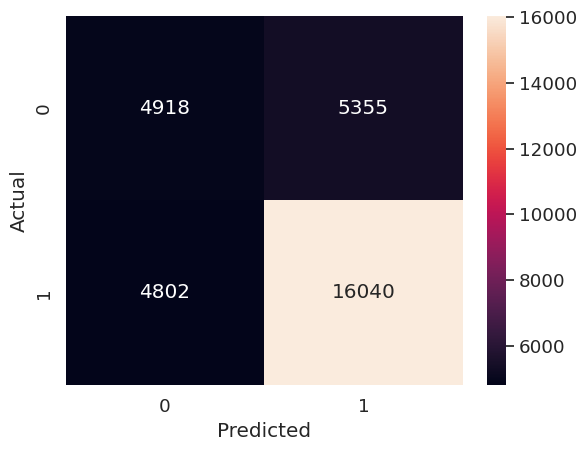

In [ ]:
'''class_report = classification_report(y_test.values, prediction_test)
print("Classification Report:")
print(class_report)'''

Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.48      0.49     10273
           1       0.75      0.77      0.76     20842

    accuracy                           0.67     31115
   macro avg       0.63      0.62      0.63     31115
weighted avg       0.67      0.67      0.67     31115

In [ ]:
'''# Make predictions
y_pred_prob = knn.predict_proba(X_test_svd)[:, 1]

#Calculate ROC Curve and AUC-ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)'''

In [ ]:
'''# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()'''

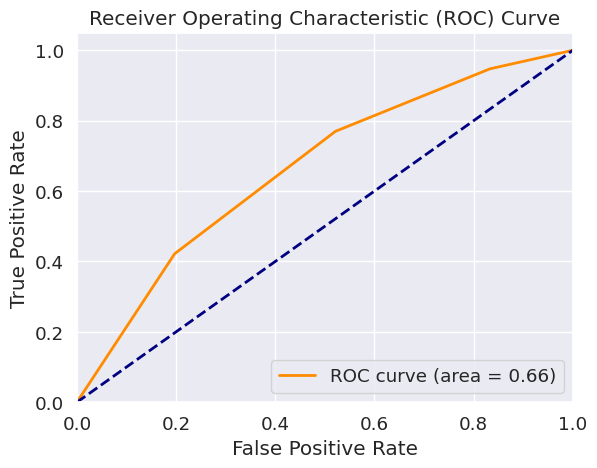

# **Cross Validation Of KNN Model**

In [ ]:
'''# fold cross-validation
scores = cross_val_score(knn, X_train_svd, y_train, cv=3)

# Print the cross-validation accuracy scores
print("Cross-validation accuracy scores:", scores)
print("Mean accuracy:", scores.mean())'''

Cross-validation accuracy scores: [0.66965555 0.67374536 0.67360073]

Mean accuracy: 0.6723338824699517

# **Hyper parameter tunning of KNN model**

**Training grid search cv for knn**

In [ ]:
'''# Perform hyperparameter tuning for KNN
k_values = [3, 5, 7]

knn = KNeighborsClassifier()
knn_model = GridSearchCV(knn, param_grid={'n_neighbors': k_values}, cv=3)
knn_model.fit(X_train_svd, y_train)'''

**Printing best parameter**

In [ ]:
'''# Print the best hyperparameters and score


print("Best hyperparameters:", knn_model.best_params_['n_neighbors'])
print("Best score:", knn_model.best_score_)

best_model_knn = knn_model.best_estimator_'''

Best hyperparameters: 7

Best score: 0.6951044372262473

In [ ]:
'''# Evaluate the model
prediction_train = best_model_knn.predict(X_train_svd)
prediction_test = best_model_knn.predict(X_test_svd)

#Calculating accuracy for both train and test data
accuracy_train=accuracy_score(y_train, prediction_train)
accuracy_test = accuracy_score(y_test, prediction_test)

# Calculate F1 scores
f1_train = f1_score(y_train, prediction_train)
f1_test = f1_score(y_test, prediction_test)

print('Accuracy_train:', accuracy_train,' Accuracy_test:',accuracy_test)
print('F_1_train:',f1_train,' F_1_test:',f1_test)'''

Accuracy_train: 0.771764195437855  Accuracy_test: 0.6977020729551663

F_1_train: 0.8364877621975088  F_1_test: 0.7827412574490691

In [ ]:
'''#Confusion Matrix
predictions=best_model_knn.predict(X_test_svd)
conf_matrix = confusion_matrix(y_test.values, predictions)
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()'''

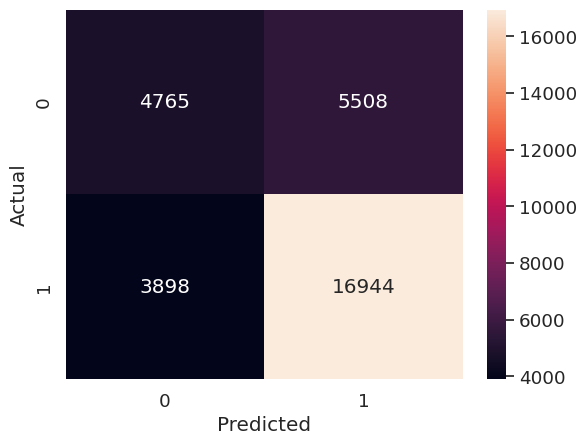

In [ ]:
'''#Classification report
class_report = classification_report(y_test.values, predictions)
print("Classification Report:")
print(class_report)'''

Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.46      0.50     10273
           1       0.75      0.81      0.78     20842

    accuracy                           0.70     31115
   macro avg       0.65      0.64      0.64     31115
weighted avg       0.69      0.70      0.69     31115

In [ ]:
'''# Step 4: Make predictions
y_pred_prob = best_model_knn.predict_proba(X_test_svd)[:, 1]

# Step 5: Calculate ROC Curve and AUC-ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)'''

In [ ]:
'''# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()'''

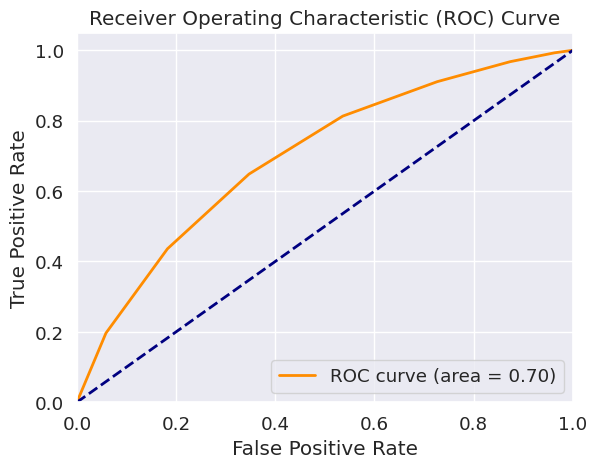

# **MODEL 3 -> Linear SVM MODEL**

**In model 3 after applying hyper parameter tunning overfitting in my model reduced and my model is performing better**

**Training Linear SVM model**

In [ ]:
# Train the SVM model
from sklearn.svm import LinearSVC
svm_model = LinearSVC(max_iter=2000)
svm_model.fit(X_train, y_train)

In [ ]:
# Evaluate the model
prediction_train = svm_model.predict(X_train)
prediction_test = svm_model.predict(X_test)

#Calculating accuracy for both train and test data
accuracy_train=accuracy_score(y_train, prediction_train)
accuracy_test = accuracy_score(y_test, prediction_test)

# Calculate F1 scores
f1_train = f1_score(y_train, prediction_train)
f1_test = f1_score(y_test, prediction_test)

print('Accuracy_train:', accuracy_train,' Accuracy_test:',accuracy_test)
print('F_1_train:',f1_train,' F_1_test:',f1_test)

**From above I can say that there is some overfitting which can be resolved using best parameters**

In [ ]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test.values, prediction_test)
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
#Classification Report
class_report = classification_report(y_test.values, prediction_test)
print("Classification Report:")
print(class_report)

In [ ]:
# Make predictions on the test data
y_pred_score = svm_model.decision_function(X_test)

# For binary classification, we can convert the decision scores to probabilities using a sigmoid function
# The decision scores represent the signed distance to the separating hyperplane
# You can use the `expit` function from scipy to compute the probabilities
y_pred_prob = expit(y_pred_score)

# Calculate ROC Curve and AUC-ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

In [ ]:
# Step 6: Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# **Cross Validation Of Linear SVM**

In [ ]:
# fold cross-validation
scores = cross_val_score(svm_model, X_train, y_train, cv=3)

# Print the cross-validation accuracy scores
print("Cross-validation accuracy scores:", scores)
print("Mean accuracy:", scores.mean())

Cross-validation accuracy scores: [0.79878034 0.79742564 0.80137878]
Mean accuracy: 0.7991949189257355

# **Hyper parameter tunning of Linear SVM**

In [ ]:
param_grid = {
    'C': [0.1, 1.0, 10.0],
    'penalty': ['l1', 'l2'],
    'loss': ['hinge', 'squared_hinge']
}

In [ ]:
# Perform grid search with cross-validation to find the best hyperparameters
grid_search = GridSearchCV(svm_model, param_grid, cv=3)
grid_search.fit(X_train, y_train)

# Print the best hyperparameters found during grid search
print("Best Hyperparameters: ", grid_search.best_params_)

# Make predictions on the test data using the best model
best_model_svm = grid_search.best_estimator_
predictions = best_model_svm.predict(X_test)

In [ ]:
# Evaluate the model
prediction_train = best_model_svm.predict(X_train)
prediction_test = best_model_svm.predict(X_test)

#Calculating accuracy for both train and test data
accuracy_train=accuracy_score(y_train, prediction_train)
accuracy_test = accuracy_score(y_test, prediction_test)

# Calculate F1 scores
f1_train = f1_score(y_train, prediction_train)
f1_test = f1_score(y_test, prediction_test)

print('Accuracy_train:', accuracy_train,' Accuracy_test:',accuracy_test)
print('F_1_train:',f1_train,' F_1_test:',f1_test)

**From above I can say that overfitting is reduced**

In [ ]:
# Step 8: Confusion Matrix
predictions=best_model_svm.predict(X_test)
conf_matrix = confusion_matrix(y_test.values, predictions)
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
#Classification report
class_report = classification_report(y_test.values, predictions)
print("Classification Report:")
print(class_report)

In [ ]:
# Make predictions on the test data
y_pred_score = best_model_svm.decision_function(X_test)

# For binary classification, we can convert the decision scores to probabilities using a sigmoid function
# The decision scores represent the signed distance to the separating hyperplane
# You can use the `expit` function from scipy to compute the probabilities
y_pred_prob = expit(y_pred_score)

# Calculate ROC Curve and AUC-ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

In [ ]:
# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# **MODEL 4 -> ComplementNB classification**

**No significant changes after hyper parameter tunning**

**Fitting Complement naive bayes**

In [ ]:
#Model Selection and Training
classifier = ComplementNB()
classifier.fit(X_train, y_train)

In [ ]:
# Evaluate the model
prediction_train = classifier.predict(X_train)
prediction_test = classifier.predict(X_test)

#Calculating accuracy for both train and test data
accuracy_train=accuracy_score(y_train, prediction_train)
accuracy_test = accuracy_score(y_test, prediction_test)

# Calculate F1 scores
f1_train = f1_score(y_train, prediction_train)
f1_test = f1_score(y_test, prediction_test)

print('Accuracy_train:', accuracy_train,' Accuracy_test:',accuracy_test)
print('F_1_train:',f1_train,' F_1_test:',f1_test)

**No Overfitting and underfitting**

Accuracy_train: 0.8587888380912589  Accuracy_test: 0.7973967539771815
F_1_train: 0.8984509068637365  F_1_test: 0.8571881654659961

In [ ]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test.values, prediction_test)
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

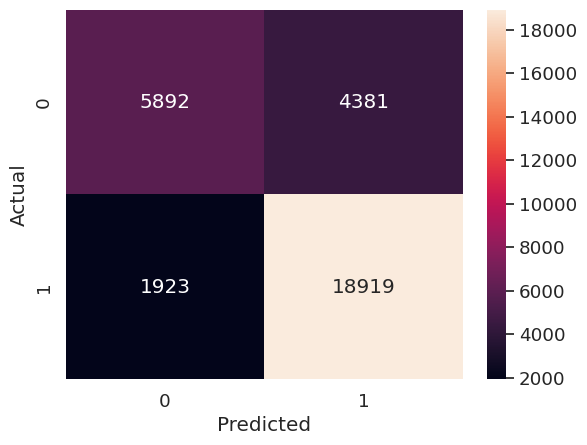

In [ ]:
class_report = classification_report(y_test.values, prediction_test)
print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.57      0.65     10273
           1       0.81      0.91      0.86     20842

    accuracy                           0.80     31115
   macro avg       0.78      0.74      0.75     31115
weighted avg       0.79      0.80      0.79     31115

In [ ]:
from sklearn.metrics import roc_curve, auc
# Step 4: Make predictions
y_pred_prob = classifier.predict_proba(X_test)[:, 1]

# Step 5: Calculate ROC Curve and AUC-ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

In [ ]:
# Step 6: Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

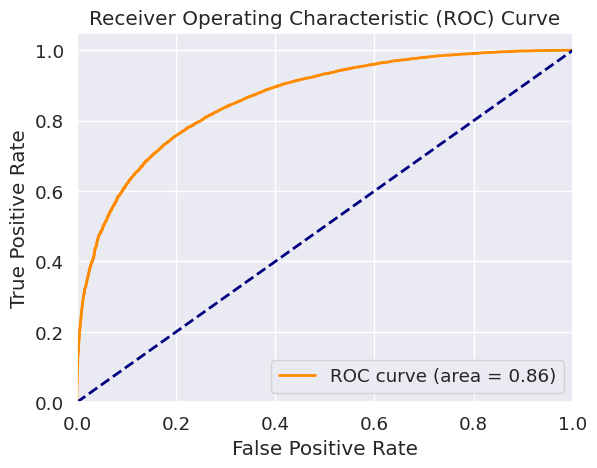

# **Cross Validation Of Complement naive bayes**

In [ ]:
# fold cross-validation
scores = cross_val_score(classifier, X_train, y_train, cv=3)

# Print the cross-validation accuracy scores
print("Cross-validation accuracy scores:", scores)
print("Mean accuracy:", scores.mean())

Cross-validation accuracy scores: [0.78925929 0.78684375 0.79038712]
Mean accuracy: 0.7888300530356744

# **Hyper parameter tunning Complement naive bayes**

In [ ]:
# Step 13: Hyperparameter Tuning
param_grid = {
    'alpha': [0.1, 0.5, 1.0, 2.0]
}
grid_search = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=3,n_jobs=-1)
grid_search.fit(X_train, y_train)

In [ ]:
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Re-train the model with the best parameters
best_classifier = ComplementNB(alpha=best_params['alpha'])
best_classifier.fit(X_train, y_train)

# Re-evaluate the model
y_pred_best = best_classifier.predict(X_test)
accuracy_best = accuracy_score(y_test, y_pred_best)
print("Accuracy with Best Parameters:", accuracy_best)

Best Parameters: {'alpha': 0.5}
Accuracy with Best Parameters: 0.7930258717660292

In [ ]:
# Evaluate the model
prediction_train = best_classifier.predict(X_train)
prediction_test = best_classifier.predict(X_test)

#Calculating accuracy for both train and test data
accuracy_train=accuracy_score(y_train, prediction_train)
accuracy_test = accuracy_score(y_test, prediction_test)

# Calculate F1 scores
f1_train = f1_score(y_train, prediction_train)
f1_test = f1_score(y_test, prediction_test)

print('Accuracy_train:', accuracy_train,' Accuracy_test:',accuracy_test)
print('F_1_train:',f1_train,' F_1_test:',f1_test)

Accuracy_train: 0.8693545665640894  Accuracy_test: 0.7930258717660292
F_1_train: 0.9021919588075358  F_1_test: 0.8468635563798925

In [ ]:
# Step 8: Confusion Matrix
predictions=best_classifier.predict(X_test)
conf_matrix = confusion_matrix(y_test.values, predictions)
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

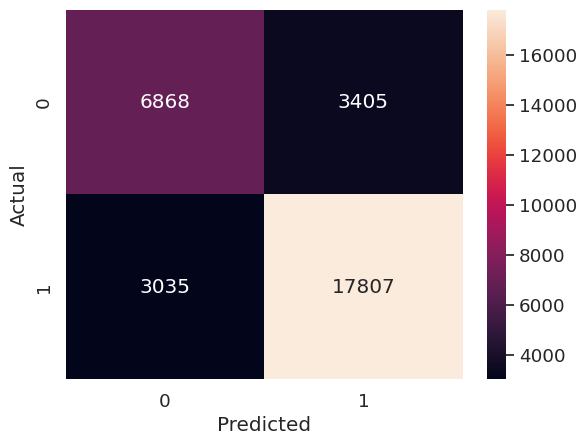

In [ ]:
class_report = classification_report(y_test.values, predictions)
print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.67      0.68     10273
           1       0.84      0.85      0.85     20842

    accuracy                           0.79     31115
   macro avg       0.77      0.76      0.76     31115
weighted avg       0.79      0.79      0.79     31115

In [ ]:
from sklearn.metrics import roc_curve, auc
# Step 4: Make predictions
y_pred_prob = best_classifier.predict_proba(X_test)[:, 1]
# Step 5: Calculate ROC Curve and AUC-ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

In [ ]:
# Step 6: Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

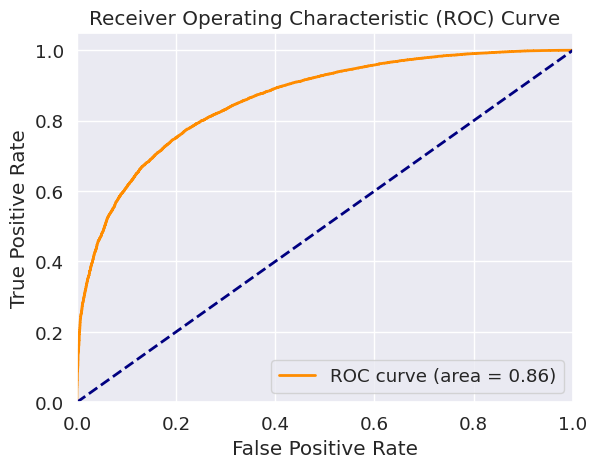

# **MODEL 5 -> Decision Tree  algorithm**

In [ ]:
'''# Train a Decision Tree classifier for sentiment analysis
d_model = DecisionTreeClassifier()
d_model.fit(X_train, y_train)'''

In [ ]:
'''# Evaluate the model
prediction_train = d_model.predict(X_train)
prediction_test = d_model.predict(X_test)

#Calculating accuracy for both train and test data
accuracy_train=accuracy_score(y_train, prediction_train)
accuracy_test = accuracy_score(y_test, prediction_test)

# Calculate F1 scores
f1_train = f1_score(y_train, prediction_train)
f1_test = f1_score(y_test, prediction_test)

print('Accuracy_train:', accuracy_train,' Accuracy_test:',accuracy_test)
print('F_1_train:',f1_train,' F_1_test:',f1_test)'''

Accuracy_train: 1.0  Accuracy_test: 0.6998232363811666

F_1_train: 1.0  F_1_test: 0.7789663006436957

In [ ]:
'''# Confusion Matrix
conf_matrix = confusion_matrix(y_test.values, prediction_test)
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()'''

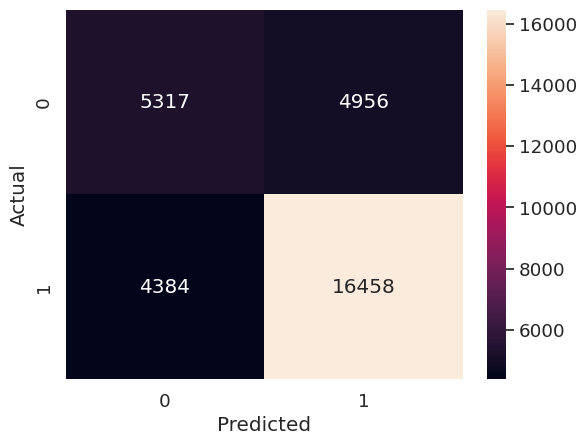

In [ ]:
'''class_report = classification_report(y_test.values, prediction_test)
print("Classification Report:")
print(class_report)'''

Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.52      0.53     10273
           1       0.77      0.79      0.78     20842

    accuracy                           0.70     31115
   macro avg       0.66      0.65      0.66     31115
weighted avg       0.70      0.70      0.70     31115

In [ ]:
'''# Step 4: Make predictions
y_pred_prob = d_model.predict_proba(X_test)[:, 1]

# Step 5: Calculate ROC Curve and AUC-ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)'''

In [ ]:
'''# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()'''

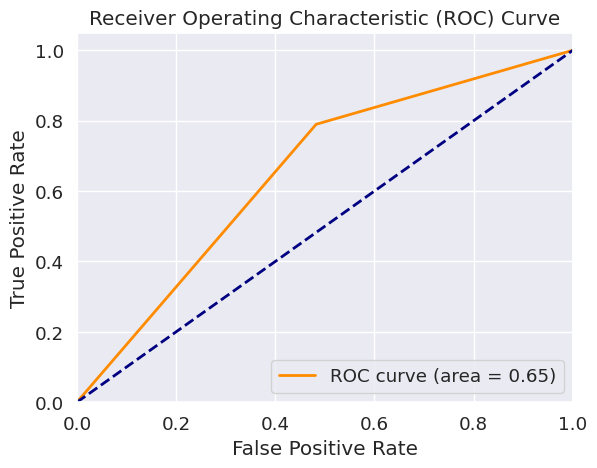

# **Hyperparameter Tunning Of decision Tree algorithm**

In [ ]:
'''#Hyperparameter tuning using GridSearchCV
param_grid = {                               # Minimum samples required to be at a leaf node
    'criterion': ['gini', 'entropy']           # Splitting criterion (Gini impurity or Information gain)
}'''

In [ ]:
'''# GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(d_model, param_grid, cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)'''

Best Hyperparameters: {'criterion': 'gini'}

In [ ]:
'''#Train the model with the best hyperparameters
d_best_model = DecisionTreeClassifier(**best_params)
d_best_model.fit(X_train, y_train)'''

In [ ]:
'''# Evaluate the model
prediction_train = d_best_model.predict(X_train)
prediction_test = d_best_model.predict(X_test)

#Calculating accuracy for both train and test data
accuracy_train=accuracy_score(y_train, prediction_train)
accuracy_test = accuracy_score(y_test, prediction_test)

# Calculate F1 scores
f1_train = f1_score(y_train, prediction_train)
f1_test = f1_score(y_test, prediction_test)

print('Accuracy_train:', accuracy_train,' Accuracy_test:',accuracy_test)
print('F_1_train:',f1_train,' F_1_test:',f1_test)'''

Accuracy_train: 1.0  Accuracy_test: 0.6987626546681664

F_1_train: 1.0  F_1_test: 0.7776433468555026

In [ ]:
'''# Step 8: Confusion Matrix
predictions=d_best_model.predict(X_test)
conf_matrix = confusion_matrix(y_test.values, predictions)
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()'''

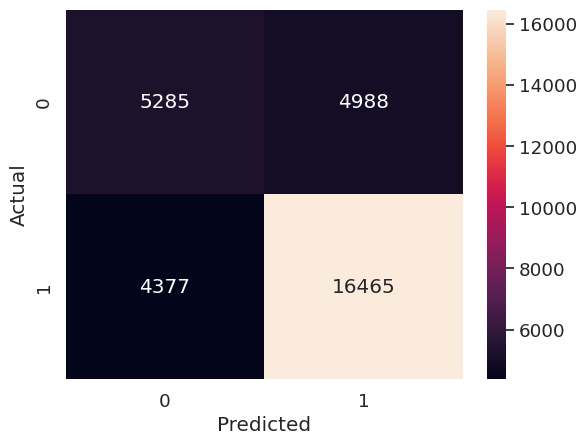

In [ ]:
'''class_report = classification_report(y_test.values, predictions)
print("Classification Report:")
print(class_report)'''

Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.51      0.53     10273
           1       0.77      0.79      0.78     20842

    accuracy                           0.70     31115
   macro avg       0.66      0.65      0.65     31115
weighted avg       0.69      0.70      0.70     31115

In [ ]:
'''# Make predictions
y_pred_prob = d_best_model.predict_proba(X_test)[:, 1]
# Calculate ROC Curve and AUC-ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)'''

In [ ]:
'''#Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()'''

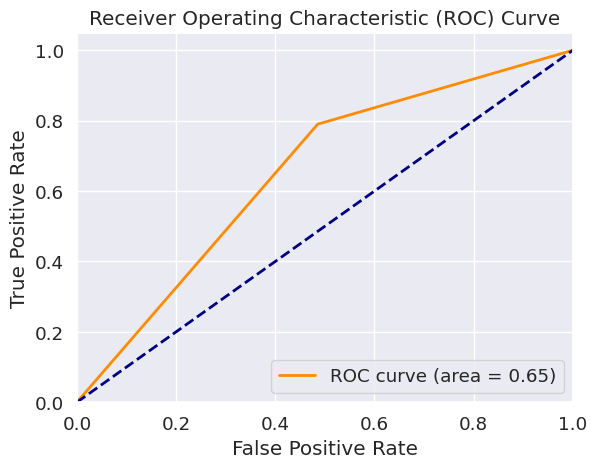

# **MODEL 6 -> Multilayer perceptron Algorithm**

In [ ]:
'''# Train the MLP classifier
mlp_classifier = MLPClassifier(hidden_layer_sizes=2)
mlp_classifier.fit(X_train, y_train)'''

In [ ]:
'''# Evaluate the model
prediction_train = mlp_classifier.predict(X_train)
prediction_test = mlp_classifier.predict(X_test)

#Calculating accuracy for both train and test data
accuracy_train=accuracy_score(y_train, prediction_train)
accuracy_test = accuracy_score(y_test, prediction_test)

# Calculate F1 scores
f1_train = f1_score(y_train, prediction_train)
f1_test = f1_score(y_test, prediction_test)

print('Accuracy_train:', accuracy_train,' Accuracy_test:',accuracy_test)
print('F_1_train:',f1_train,' F_1_test:',f1_test)'''

Accuracy_train: 0.9885665158807319  Accuracy_test: 0.7389040655632332

F_1_train: 0.9914981329350261  F_1_test: 0.8043729531882103

In [ ]:
'''# Confusion Matrix
conf_matrix = confusion_matrix(y_test.values, prediction_test)
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()'''

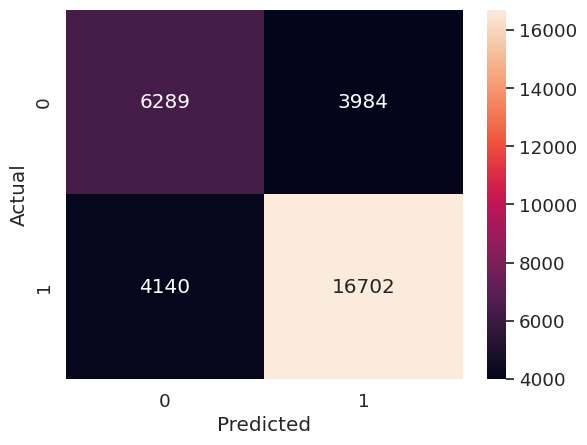

In [ ]:
'''class_report = classification_report(y_test.values, prediction_test)
print("Classification Report:")
print(class_report)'''

Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.61      0.61     10273
           1       0.81      0.80      0.80     20842

    accuracy                           0.74     31115
   macro avg       0.71      0.71      0.71     31115
weighted avg       0.74      0.74      0.74     31115


In [ ]:
'''# Step 4: Make predictions
y_pred_prob = mlp_classifier.predict_proba(X_test)[:, 1]

# Step 5: Calculate ROC Curve and AUC-ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)'''

In [ ]:
'''#Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()'''

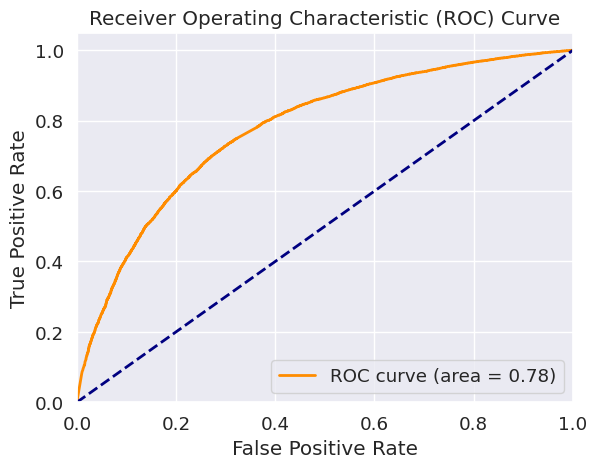

**I have not performed hyper parameter tunning of MLP classifier because its taking very long time**

**Number of reviewer who are top critic** 

In [ ]:
len((test_data[test_data['isTopCritic']==True])['reviewerName'].unique())

# **Imputing missing reviews in my test_data**

In [ ]:
missing_reviews = test_data['reviewText'].isnull().sum()
print(f"Number of missing reviews: {missing_reviews}")

# Convert the 'reviewText' column to a numpy array
review_text = np.array(test_data['reviewText'])

# Reshape the data to a 2D array
review_text_2d = review_text.reshape(-1, 1)

imputer = SimpleImputer(strategy='most_frequent')
imputed_reviews = imputer.fit_transform(review_text_2d)

# Update the 'reviewText' column with the imputed values
test_data['reviewText'] = imputed_reviews

missing_reviews_after_imputation = test_data['reviewText'].isnull().sum()
print(f"Number of missing reviews after imputation: {missing_reviews_after_imputation}")

# **Cleaning reviewText in test_data**

In [ ]:
test_data['reviewText']=test_data['reviewText'].apply(clean_review_text)

In [ ]:
test_data.isnull().sum()

# **Using SimpleImputer to impute missing audience score using mean strategy**

In [ ]:
from sklearn.impute import SimpleImputer

# Selecting column
numeric_columns = test_data.select_dtypes(include=['number']).columns

# Impute numeric columns using mean imputation
numeric_imputer = SimpleImputer(strategy='mean')
test_data[numeric_columns] = numeric_imputer.fit_transform(test_data[numeric_columns])

**Vectorize reviewText**

In [ ]:
data_test = vectorizer.transform(test_data['reviewText'])

In [ ]:
test_data.head()

**Adding audience Score as one of the feature in vectorizer**

In [ ]:
data_test = hstack((data_test, test_data['audienceScore_y'].values.reshape(-1, 1)))

# **Generating submission.csv**

In [ ]:
predictions = best_model_1.predict(data_test)

# Create a submission DataFrame
sub = pd.DataFrame(predictions, columns=['sentiment'])
sub['sentiment'].replace({1: 'POSITIVE', 0: 'NEGATIVE'}, inplace=True)
sub.index.name = 'id'

# Save the submission DataFrame to a CSV file
sub.to_csv("submission.csv", encoding='utf-8')
print("submission.csv file generated successfully")

**Three best model I got is-**
1. Logistic Regression model
2. Linear support vector machine
3. Complement naive bayes

**Comparision between these Three models before hyper parameter tunning**

model 1 Logistic regression

Accuracy_train: 0.8546991378686957  Accuracy_test: 0.8097380684557287
F_1_train: 0.8962216509044165  F_1_test: 0.865012769062386

model 2 Linear svm

Accuracy_train: 0.9190094729991403  Accuracy_test: 0.8029567732604853
F_1_train: 0.9405576260791622  F_1_test: 0.8567623764689392

model 3 Complement navie bayes
​
Accuracy_train: 0.8587888380912589  Accuracy_test: 0.7973967539771815
F_1_train: 0.8984509068637365  F_1_test: 0.8571881654659961

**From above I can say that Logistic regression is performing well**

**Comparision between these Three models after hyper parameter tunning**

model 1 Logistic regression

Accuracy_train: 0.8546991378686957  Accuracy_test: 0.8097380684557287
F_1_train: 0.8962216509044165  F_1_test: 0.865012769062386

model 2 Linear svm

Accuracy_train: 0.8842510384946046  Accuracy_test: 0.8085810702233649
F_1_train: 0.916102731349368  F_1_test: 0.8624162624162625


model 3 Complement navie bayes

Accuracy_train: 0.8693545665640894  Accuracy_test: 0.7930258717660292
F_1_train: 0.9021919588075358  F_1_test: 0.8468635563798925


**From above I can say that Logistic Regression is performing well**